#Computer Vision Path
###3D MRI Segmentation

This project builds upon my previous project in which I learnt about computer vision and used deep learning framework tensorflow to train and test a U net model that segments 2D brain MRI scans to look for tumors.

In this project I will train and test a U net model that will do the same but with 3D MRI scans and this will be much more closer to real life application.
I will be using AI to assist me in this project as this is a learning experience for me.

So, Our goal is to build a model that can process an entire 3D MRI volume and produce a 3D segmentation map of a brain tumor

Lastly, an idea for this project is that I will try to do this project in a  complete MLOps pipeline and try to create a FastAPI and deploy the model.

The following code block shows the working of a 3D U net model that we will use for our project

In [4]:
'''
[ 3D MRI Input Volume ]
(e.g., 128x128x128x4)
        |
        V
+---------------------+
|   ENCODER PATH      |
| (Contraction)       |
| - 3D Conv Blocks    |
| - 3D Max Pooling    |
| (Shrinks Volume,    |
|  Extracts Features) |
+---------------------+
        |
        V
+---------------------+
|     BOTTLENECK      |
| (Smallest Feature   |
|  Representation)    |
+---------------------+
        |
        V
+---------------------+
|    DECODER PATH     |
| (Expansion)         |
| - 3D Transposed Conv|
| - Skip Connections  |
| - 3D Conv Blocks    |
| (Expands Volume,    |
|  Localizes Features)|
+---------------------+
        |
        V
[ Final 3D Mask Output ]
(e.g., 128x128x128x1)
'''

'''
Input (128x128x128)
  |
  +--> [Conv Block 1] ---> Output_1 (128x128x128)
  |        |
  |        V
  |    [Max Pool]
  |        |
  |        V
  +--> [Conv Block 2] ---> Output_2 (64x64x64)
  |        |
  |        V
  |    [Max Pool]
  |        |
  |        V
  |   [Bottleneck Conv Block]
  |        |
  |        V
  |  [Transposed Conv] --- (merge with Output_2 via Skip Connection)
  |        |
  |        V
  +---- [Conv Block 3]
           |
           V
     [Transposed Conv] --- (merge with Output_1 via Skip Connection)
           |
           V
       [Conv Block 4]
           |
           V
      Final Output Mask (128x128x128)
'''

'\nInput (128x128x128)\n  |\n  +--> [Conv Block 1] ---> Output_1 (128x128x128)\n  |        |\n  |        V\n  |    [Max Pool]\n  |        |\n  |        V\n  +--> [Conv Block 2] ---> Output_2 (64x64x64)\n  |        |\n  |        V\n  |    [Max Pool]\n  |        |\n  |        V\n  |   [Bottleneck Conv Block]\n  |        |\n  |        V\n  |  [Transposed Conv] --- (merge with Output_2 via Skip Connection)\n  |        |\n  |        V\n  +---- [Conv Block 3]\n           |\n           V\n     [Transposed Conv] --- (merge with Output_1 via Skip Connection)\n           |\n           V\n       [Conv Block 4]\n           |\n           V\n      Final Output Mask (128x128x128)\n'

In [2]:
from google.colab import files
# This will prompt you to upload your kaggle.json file
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# --- 2. Download the BraTS 2020 Dataset (Corrected Command) ---
# We are now using 'kaggle datasets download -d'
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.15G/4.16G [00:47<00:00, 39.0MB/s]
100% 4.16G/4.16G [00:48<00:00, 92.9MB/s]


In [5]:
# The zip file will have a different name now, so we unzip the correct one.
!unzip -q brats20-dataset-training-validation.zip -d brats2020_data

In [4]:
# --- 4. Install the necessary library for medical imaging ---
!pip install nibabel

--- Directory Listing ---
BraTS20_Training_001_flair.nii	BraTS20_Training_001_t1.nii
BraTS20_Training_001_seg.nii	BraTS20_Training_001_t2.nii
BraTS20_Training_001_t1ce.nii

--- Loading Scan ---
Shape of the 3D scan: (240, 240, 155)
Data type: float64


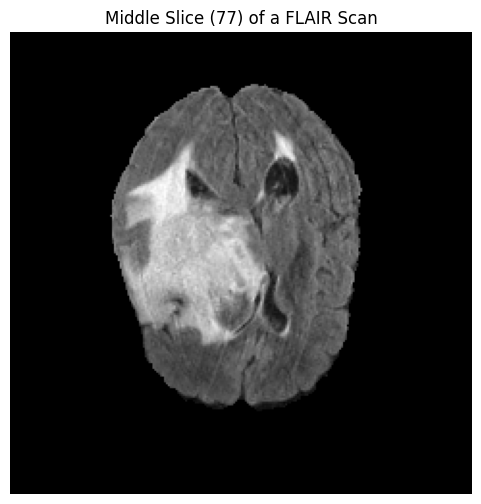

In [5]:
import nibabel as nib
import matplotlib.pyplot as plt
import os
import numpy as np

# --- Let's first list the directories to confirm the structure ---
print("--- Directory Listing ---")
!ls brats2020_data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/

# --- Define the CORRECTED path to our data ---
# The patient folders are inside the 'MICCAI_BraTS2020_TrainingData' directory
data_path = 'brats2020_data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

# --- Pick a single patient folder to inspect ---
patient_folder = 'BraTS20_Training_001'
patient_path = os.path.join(data_path, patient_folder)

# Construct the full path to the FLAIR scan file
# The file names are likely nested within the patient folder directly
flair_scan_path = os.path.join(patient_path, f'{patient_folder}_flair.nii')

# --- Load the 3D Scan using nibabel ---
print("\n--- Loading Scan ---")
flair_scan = nib.load(flair_scan_path)

# --- Get the data as a NumPy array ---
flair_array = flair_scan.get_fdata()

# --- Inspect the data ---
print(f"Shape of the 3D scan: {flair_array.shape}")
print(f"Data type: {flair_array.dtype}")

# --- Visualize a single 2D slice from the middle of the 3D volume ---
middle_slice_index = flair_array.shape[2] // 2
middle_slice = flair_array[:, :, middle_slice_index]

plt.figure(figsize=(6, 6))
plt.imshow(middle_slice.T, cmap='gray', origin='lower')
plt.title(f'Middle Slice ({middle_slice_index}) of a FLAIR Scan')
plt.axis('off')
plt.show()

In [6]:
# List the contents of the main data directory to understand the structure
!ls brats2020_data/

BraTS2020_TrainingData	BraTS2020_ValidationData


In [7]:
# List the contents of the training data directory
!ls brats2020_data/BraTS2020_TrainingData/

MICCAI_BraTS2020_TrainingData


In [8]:
data_path = 'brats2020_data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

# --- Pick a single patient folder to process ---
patient_folder = 'BraTS20_Training_001'
patient_path = os.path.join(data_path, patient_folder)

# --- Load all 5 volumes for the patient ---
modalities = ['flair', 't1', 't1ce', 't2', 'seg']
patient_volumes = {}

for mod in modalities:
    # Construct the full path using the correct .nii extension
    scan_path = os.path.join(patient_path, f'{patient_folder}_{mod}.nii')

    # Load the 3D Scan and get its data as a NumPy array
    patient_volumes[mod] = nib.load(scan_path).get_fdata()
    print(f"Loaded '{mod}' with shape: {patient_volumes[mod].shape}")


# --- Stack the 4 input modalities into a single 4D array ---
# We stack them along a new, final axis to create the channels
combined_scan = np.stack([
    patient_volumes['flair'],
    patient_volumes['t1'],
    patient_volumes['t1ce'],
    patient_volumes['t2']
], axis=-1)

# The segmentation mask is our target, so we keep it separate
segmentation_mask = patient_volumes['seg']


# --- Inspect the final prepared data ---
print("\n--- Final Shapes ---")
print(f"Shape of the combined input scan: {combined_scan.shape}")
print(f"Shape of the segmentation mask: {segmentation_mask.shape}")

Loaded 'flair' with shape: (240, 240, 155)
Loaded 't1' with shape: (240, 240, 155)
Loaded 't1ce' with shape: (240, 240, 155)
Loaded 't2' with shape: (240, 240, 155)
Loaded 'seg' with shape: (240, 240, 155)

--- Final Shapes ---
Shape of the combined input scan: (240, 240, 155, 4)
Shape of the segmentation mask: (240, 240, 155)


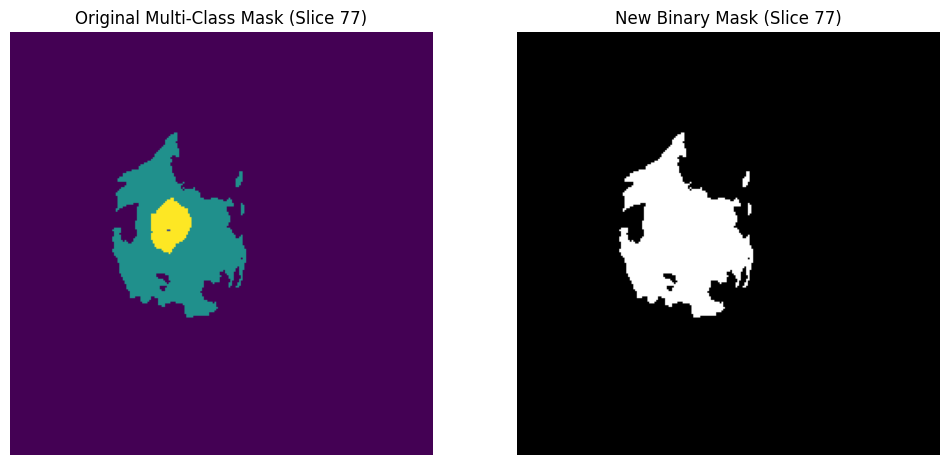

Unique values in the original mask: [0. 1. 2. 4.]
Unique values in the new binary mask: [0 1]


In [9]:
# --- Visualize the original multi-class segmentation mask ---
middle_slice_index = segmentation_mask.shape[2] // 2
original_mask_slice = segmentation_mask[:, :, middle_slice_index]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
# We use a color map to see the different integer labels
plt.imshow(original_mask_slice.T, cmap='viridis', origin='lower')
plt.title(f'Original Multi-Class Mask (Slice {middle_slice_index})')
plt.axis('off')


# --- Simplify the mask to a binary format ---
# Any voxel with a label > 0 is considered part of the tumor.
# We convert the boolean mask (True/False) to an integer mask (1/0).
binary_mask = (segmentation_mask > 0).astype(np.uint8)
binary_mask_slice = binary_mask[:, :, middle_slice_index]

# --- Visualize the new binary mask ---
plt.subplot(1, 2, 2)
plt.imshow(binary_mask_slice.T, cmap='gray', origin='lower')
plt.title(f'New Binary Mask (Slice {middle_slice_index})')
plt.axis('off')

plt.show()

# Verify the unique values in the new binary mask
print("Unique values in the original mask:", np.unique(segmentation_mask))
print("Unique values in the new binary mask:", np.unique(binary_mask))

In [10]:
#using combined_scan and binary_mask in the previous code block

#Verifying the shape of these two
print(f"Shape of combined_scan: {combined_scan.shape}")
print(f"Shape of binary_mask: {binary_mask.shape}")

#We are doing this to crop the image and get rid of all the black space
#Finding the coordinates of all the non zero voxels

#Again, We will check only one channel For example the FLAIR channel

non_zero_indices = np.where(combined_scan[:, :, :, 0] != 0)

#Printing out the shape of the output
print("\nShape of the coordinates array:", non_zero_indices[0].shape)

Shape of combined_scan: (240, 240, 155, 4)
Shape of binary_mask: (240, 240, 155)

Shape of the coordinates array: (1342885,)


In [11]:
#Now we will find  the minimum corner of the bounding box
min_indices = np.min(non_zero_indices, axis = 1)

#Next we find the maximum corner of the bounding box in the same way
max_indices = np.max(non_zero_indices, axis = 1)

#Printing them out
print(f"Bounding Box Min Corner (x,y,z): {min_indices}")
print(f"Bounding Box Max Corner (x,y,z): {max_indices}")


#Now we have the coordinates, We will use these coordinates to crop the scan and the mask
scan_cropped = combined_scan[min_indices[0]:max_indices[0], min_indices[1]:max_indices[1], min_indices[2]:max_indices[2]]
mask_cropped = binary_mask[min_indices[0]:max_indices[0], min_indices[1]:max_indices[1], min_indices[2]:max_indices[2]]

print(f"\nOriginal scan shape: {combined_scan.shape}")
print(f"Cropped scan shape: {scan_cropped.shape}")

Bounding Box Min Corner (x,y,z): [49 42  4]
Bounding Box Max Corner (x,y,z): [185 214 138]

Original scan shape: (240, 240, 155, 4)
Cropped scan shape: (136, 172, 134, 4)


In [12]:
#Next step would be to normalize

#Now again we will only select the non zero voxels from the cropped scan
#In the previous step we cropped the image into a smaller bounding box

brain_voxels = scan_cropped[scan_cropped != 0]

#Now we will calculate the mean and standard deviation of these brain voxels
mean = np.mean(brain_voxels)
std = np.std(brain_voxels)

#Now we will normalize the scan
scan_normalized = (scan_cropped - mean)/std

#The background (orginally 0) now has a non zero value. We have to set it to the new minimum
scan_normalized[scan_cropped == 0] = np.min(scan_normalized)

print(f"Mean of normalized brain tissue: {scan_normalized[scan_cropped != 0].mean():.2f}")
print(f"Std Dev of normalized brain tissue: {scan_normalized[scan_cropped != 0].std():.2f}")

Mean of normalized brain tissue: -0.00
Std Dev of normalized brain tissue: 1.00


In [13]:
#Since we cropped based on the non zero pixels and the bounding box is also based on that. So, each patient's brain volume will
#slightly different shape. So we need to resize everything to have a standard 128 x 128 x 128 cube.

from scipy.ndimage  import zoom

#this is our target shape/dimension
target_shape = (64, 64, 64)

#Calculating the resize factors for each dimension
current_shape = mask_cropped.shape
resize_factors = [t / s for t, s in zip(target_shape, current_shape)]

#Resizing the mask
#using order=0 (nearest neighbour) for the mask to keep the 0s and 1s intact
mask_resized = zoom(mask_cropped, resize_factors, order=0)

#Resizing the 4 channel normalized scan
scan_resized = np.stack([
    zoom(scan_normalized[:, :, :, i], resize_factors, order =1) for i in range(4)
], axis=-1)

print(f"\nFinal scan shape: {scan_resized.shape}")
print(f"Final mask shape: {mask_resized.shape}")


Final scan shape: (64, 64, 64, 4)
Final mask shape: (64, 64, 64)


###Preprocessing Function:
The code above shows us the main idea of preprocessing. We also want to create a function that would take a small batch of our data and preprocess it using the above given techniques. Basically a preprocessing pipeline


## Blueprint for Your Own Preprocessing Functions
When you start a new project, here's a checklist of what to keep in mind for your preprocessing function.

What's the Goal? Consistency. The primary goal is to transform your raw, varied data into a perfectly consistent format. Every single sample fed to your model must have the exact same shape and data range.

Unify the Shape:

Is there irrelevant information I can crop out (e.g., empty space, image borders)?

What is the final, fixed size that all my samples need to be? (e.g., 128x128x128). Use padding or resizing (zoom) to enforce this.

Standardize the Values (Normalization):

How will I scale my input features? Common choices are Z-score normalization (mean=0, std=1) or Min-Max scaling (to a [0, 1] or [-1, 1] range).

Make sure you calculate statistics (like mean, std) only on your training set and then apply them to your validation and test sets.

Prepare the Target Variable:

What format does my model's loss function expect?

Do I need to convert a multi-class mask to a binary one?

Do I need to one-hot encode my labels for a multi-class classification problem?

Be Robust (try...except):

Real-world datasets often have corrupted or missing files. Always wrap your file-loading and processing logic in a try...except block. This prevents your entire multi-hour pipeline from crashing because of one bad file.

Be Efficient (Save Your Work):

Preprocessing can be very slow. It's almost always a good idea for your function to save the final, processed arrays to disk (e.g., as .npy files). This way, you can run the slow pipeline once and then load the clean data instantly for all future experiments.

In [31]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.ndimage  import zoom # Import zoom

def preprocess_and_save(patient_id, base_path, save_path_scans, save_path_masks):
    try:
        # Get the full path to the patient's folder
        patient_path = os.path.join(base_path, patient_id)

        # Load Scans and Mask
        modalities = ['flair', 't1', 't1ce', 't2']
        scan_volumes = [nib.load(os.path.join(patient_path, f'{patient_id}_{mod}.nii')).get_fdata() for mod in modalities]
        # Correct the file extension for the segmentation mask
        seg_mask = nib.load(os.path.join(patient_path, f'{patient_id}_seg.nii')).get_fdata()

        # Stack scans and create a binary mask
        scan_stacked = np.stack(scan_volumes, axis=-1)
        mask_binary = (seg_mask > 0).astype(np.uint8)

        # Crop to Brain Region
        non_zero_indices = np.where(scan_stacked[:, :, :, 0] != 0)
        min_indices = np.min(non_zero_indices, axis=1)
        max_indices = np.max(non_zero_indices, axis=1)
        scan_cropped = scan_stacked[min_indices[0]:max_indices[0], min_indices[1]:max_indices[1], min_indices[2]:max_indices[2], :]
        mask_cropped = mask_binary[min_indices[0]:max_indices[0], min_indices[1]:max_indices[1], min_indices[2]:max_indices[2]]

        # Normalize the Cropped Scan
        brain_voxels = scan_cropped[scan_cropped != 0]
        mean = brain_voxels.mean()
        std = brain_voxels.std()
        scan_normalized = (scan_cropped - mean) / std
        scan_normalized[scan_cropped == 0] = np.min(scan_normalized)

        # Resize/Pad to a standard shape
        target_shape = (64, 64, 64) # Changed target shape to 64x64x64
        resize_factors = [t / s for t, s in zip(target_shape, mask_cropped.shape)]
        mask_resized = zoom(mask_cropped, resize_factors, order=0)
        scan_resized = np.stack([zoom(scan_normalized[:,:,:,i], resize_factors, order=1) for i in range(4)], axis=-1)

        # Save the processed arrays
        np.save(os.path.join(save_path_scans, f'{patient_id}_scan.npy'), scan_resized)
        np.save(os.path.join(save_path_masks, f'{patient_id}_mask.npy'), mask_resized)


        return True
    except Exception as e:
        print(f"Error processing {patient_id}: {e}")
        return False

#Getting and Splitting the Patient ID
data_path = 'brats2020_data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
all_patient_ids = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

train_val_ids, test_ids = train_test_split(all_patient_ids, test_size=0.15, random_state=42)
train_ids, val_ids = train_test_split(train_val_ids, test_size=0.15, random_state=42)

print(f"Total patients: {len(all_patient_ids)}")
print(f"Training patients: {len(train_ids)}")
print(f"Validation patients: {len(val_ids)}")
print(f"Test patients: {len(test_ids)}")

#Process and save subset of the data
# Create directories to save the processed data
os.makedirs('processed_data/train/scans', exist_ok=True)
os.makedirs('processed_data/train/masks', exist_ok=True)
os.makedirs('processed_data/val/scans', exist_ok=True)
os.makedirs('processed_data/val/masks', exist_ok=True)
os.makedirs('processed_data/test/scans', exist_ok=True)
os.makedirs('processed_data/test/masks', exist_ok=True)

# Process a small subset to test the pipeline
print("\n--- Processing a small subset of training data ---")
for patient_id in tqdm(train_ids[:5]): # Using tqdm for a progress bar
    save_path_scans = 'processed_data/train/scans'
    save_path_masks = 'processed_data/train/masks'
    preprocess_and_save(patient_id, data_path, save_path_scans, save_path_masks)


print("\n--- Processing a small subset of validation data ---")
for patient_id in tqdm(val_ids[:2]):
    save_path_scans = 'processed_data/val/scans'
    save_path_masks = 'processed_data/val/masks'
    preprocess_and_save(patient_id, data_path, save_path_scans, save_path_masks)

print("\n--- Processing a small subset of test data ---")
for patient_id in tqdm(test_ids[:2]): # Process a small subset of test data
    save_path_scans = 'processed_data/test/scans'
    save_path_masks = 'processed_data/test/masks'
    preprocess_and_save(patient_id, data_path, save_path_scans, save_path_masks)


print("\nSubset processing complete!")

Total patients: 369
Training patients: 266
Validation patients: 47
Test patients: 56

--- Processing a small subset of training data ---


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]



--- Processing a small subset of validation data ---


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]



--- Processing a small subset of test data ---


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


Subset processing complete!


###Building the 3D U-net Model

In [15]:
import tensorflow as tf

def build_3d_unet(input_shape):

  inputs = tf.keras.layers.Input(shape=input_shape)

  #First we define the encoder
  #Going down 2 levels

  #Level 1
  c1 = tf.keras.layers.Conv3D(16, (3, 3, 3), activation = "relu", padding='same')(inputs)
  c1 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation = "relu", padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling3D((2,2,2))(c1)


  #Level 2
  c2 = tf.keras.layers.Conv3D(64, (3, 3, 3), activation = "relu", padding='same')(p1)
  c2 = tf.keras.layers.Conv3D(128, (3, 3, 3), activation="relu", padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling3D((2,2,2))(c2)


  #At this point our encoder is done. We just have to code the bottleneck

  #Bottleneck
  c_middle = tf.keras.layers.Conv3D(256, (3, 3, 3), activation="relu", padding= "same")(p2)
  c_middle = tf.keras.layers.Conv3D(256, (3, 3, 3), activation="relu", padding= "same")(c_middle)

  #Now we will code the Decoder
  #In similar fashion now we go 2 levels up

  #Level 3
  u3 = tf.keras.layers.Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c_middle)
  u3 = tf.keras.layers.Concatenate()([u3, c2]) #Skip the connection
  c3 = tf.keras.layers.Conv3D(128, (3, 3, 3), activation="relu", padding='same')(u3)
  c3 = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c3)

  #Level 4
  u4 = tf.keras.layers.Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c3)
  u4 = tf.keras.layers.Concatenate()([u4, c1]) #Skip the connection
  c4 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation="relu", padding='same')(u4)
  c4 = tf.keras.layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(c4)

  #Final Output
  #This would be a final 1x1x1 convolution with a sigmoid activation for binary segmentation
  outputs = tf.keras.layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(c4)


  #Now we create the model
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  return model


#Instantiate and Inspecting the model
#Our input shape is (128, 128, 128, 4)

input_shape = (64, 64, 64, 4) # Corrected input shape
model = build_3d_unet(input_shape)


#Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 4)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_11 (Conv3D)  │ (None, 64, 64,    │      1,744 │ input_layer_1[0]… │
│                     │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_12 (Conv3D)  │ (None, 64, 64,    │     13,856 │ conv3d_11[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 32, 32,    │          0 │ conv3d_12[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_13 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_2[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_14 (Conv3D)  │ (None, 32, 32,    │    221,312 │ conv3d_13[0][0]   │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 16, 16,    │          0 │ conv3d_14[0][0]   │
│ (MaxPooling3D)      │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_15 (Conv3D)  │ (None, 16, 16,    │    884,992 │ max_pooling3d_3[… │
│                     │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 16, 16,    │  1,769,728 │ conv3d_15[0][0]   │
│                     │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_2  │ (None, 32, 32,    │    262,272 │ conv3d_16[0][0]   │
│ (Conv3DTranspose)   │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ conv3d_transpose… │
│ (Concatenate)       │ 32, 256)          │            │ conv3d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_17 (Conv3D)  │ (None, 32, 32,    │    884,864 │ concatenate_2[0]… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_18 (Conv3D)  │ (None, 32, 32,    │    221,248 │ conv3d_17[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_3  │ (None, 64, 64,    │     16,416 │ conv3d_18[0][0]   │
│ (Conv3DTranspose)   │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ conv3d_transpose… │
│ (Concatenate)       │ 64, 64)           │            │ conv3d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 64, 64,    │     55,328 │ concatenate_3[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 64, 64,    │     13,840 │ conv3d_19[0][0] 

 Total params: 4,400,977 (16.79 MB)

 Trainable params: 4,400,977 (16.79 MB)

 Non-trainable params: 0 (0.00 B)

###Creating The Data Generator
We can't load all the processed 3D volumes into memory at once we would run out of RAM in Colab very quickly.

The modern and most efficient way to handle this in TensorFlow is to use the tf.data.Dataset API. We will create a Python generator, which is a special function that loads one data sample at a time from our disk, yields it to the model, and then moves on to the next one. This method is highly memory-efficient.

In [16]:
def data_generator(patient_ids, data_path, batch_size):

  #Creates batches of preprocessed 3D scans and masks

  #Getting the full paths to the scan and mask files
  scan_paths = [os.path.join(data_path, 'scans', f'{pid}_scan.npy')for pid in patient_ids]
  mask_paths = [os.path.join(data_path, 'masks', f'{pid}_mask.npy') for pid in patient_ids]


  dataset_size = len(scan_paths)
  indices = np.arange(dataset_size)

  while True: #This will loop indefinitely for training
    #Shuffle the data at the start of each epoch
    np.random.shuffle(indices)

    for i in range(0, dataset_size, batch_size):
      batch_indices = indices[i:i+batch_size]

      #Initialize empty lists for the batch
      batch_scans = []
      batch_masks = []

      for idx in batch_indices:
        #load the scan and maks for the current index
        scan = np.load(scan_paths[idx])
        mask = np.load(mask_paths[idx])


        #The mask needs an extra channel dimension for the loss function
        mask = np.expand_dims(mask, axis=-1)

        batch_scans.append(scan)
        batch_masks.append(mask)

      #Yield the completed batch

      yield np.array(batch_scans), np.array(batch_masks)

#Create the tf.data.Dataset object
BATCH_SIZE = 1 #Using a small batch size due to the large size of 3D volumes


#Creating the training dataset using the processed subset
train_gen  = data_generator(train_ids[:5], 'processed_data/train', BATCH_SIZE)
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 64, 64, 64, 4), dtype=tf.float32), # Changed shape to 64
        tf.TensorSpec(shape=(None, 64, 64, 64, 1), dtype=tf.uint8) # Changed shape to 64
    )

)


#Create the validation dataset using the processed subset
val_gen = data_generator(val_ids[:2], 'processed_data/val', BATCH_SIZE)
val_dataset = tf.data.Dataset.from_generator(
    lambda: val_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 64, 64, 64, 4), dtype=tf.float32), # Changed shape to 64
        tf.TensorSpec(shape=(None, 64, 64, 64, 1), dtype=tf.uint8) # Changed shape to 64
    )
)


#Verify the output of one batch
print("Verifying one batch from the training dataset")
for scan_batch, mask_batch in train_dataset.take(1):
    print("Scan batch shape:", scan_batch.shape)
    print("Mask batch shape:", mask_batch.shape)

Verifying one batch from the training dataset
Scan batch shape: (1, 64, 64, 64, 4)
Mask batch shape: (1, 64, 64, 64, 1)


###Model Compilation and Custom Loss
For segmentation tasks, especially with imbalanced classes (the tumor is a very small part of the total 3D volume), the standard binary_crossentropy loss can sometimes struggle.

A much more powerful approach is to use a loss function that directly maximizes the overlap between the predicted mask and the true mask. We will use a combination of Dice Loss and Binary Cross-Entropy, which is a state-of-the-art standard for medical segmentation. We will also monitor the Dice Coefficient as our main performance metric.

In [17]:
import tensorflow.keras.backend as K

#Defining Dice Coefficient Metrics

#This will monitor to see how well the segmentation is performing, This is our main metric to keep an eye on

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Ensure both inputs are float32 for calculation
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f) # Corrected multiplication
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


#Now we will define the combined loss function
#This loss function will combine dice coefficient with binary cross entropy and be used as the main metric
def dice_loss_plus_bce(y_true, y_pred):

  #Making sure y_true and y_pred are float32 for loss calculation
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
  dice_loss = 1 - dice_coefficient(y_true, y_pred)

  return bce + dice_loss


#Now we will compile our model wih Adam optimizer and new loss function

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=dice_loss_plus_bce,
    metrics=[dice_coefficient]
)

print("Model compiled successfully!")

Model compiled successfully!


In [20]:
# --- Define Callbacks ---
# This saves the best version of the model based on the validation dice coefficient
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_3d_unet_model.keras',
    monitor='val_dice_coefficient',
    save_best_only=True,
    mode='max',
    verbose=1
)

# This stops training if the validation dice coefficient doesn't improve for 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_dice_coefficient',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# --- Calculate Steps for Generator ---
# We need to tell Keras how many batches to run for each epoch.
steps_per_epoch = len(train_ids) // BATCH_SIZE
validation_steps = len(val_ids) // BATCH_SIZE

# --- Train the Model ---
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping]
)

print("\nTraining complete!")

Epoch 1/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - dice_coefficient: 0.5945 - loss: 0.4774 
Epoch 1: val_dice_coefficient improved from -inf to 0.70803, saving model to best_3d_unet_model.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 4498s 17s/step - dice_coefficient: 0.5952 - loss: 0.4767 - val_dice_coefficient: 0.7080 - val_loss: 0.4194
Epoch 2/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - dice_coefficient: 0.8863 - loss: 0.1366 
Epoch 2: val_dice_coefficient did not improve from 0.70803
266/266 ━━━━━━━━━━━━━━━━━━━━ 4523s 17s/step - dice_coefficient: 0.8864 - loss: 0.1366 - val_dice_coefficient: 0.6638 - val_loss: 0.5424
Restoring model weights from the end of the best epoch: 1.

Training complete!


#Update
At this point I just have a model that is trained on 2 epochs as the time it was requiring to train the model was a very long time and I will come back to it and train it on 50 epochs when I upgrade my colab plan

# Task
Explain the error in the selected code. If possible, fix the error and incorporate the changes into the existing code. Otherwise, try to diagnose the error.

## Refactor test data loading

### Subtask:
Create a new function that takes a patient ID and loads/preprocesses a single test sample (scan and mask) without batching.


**Reasoning**:
The goal is to create a function to load and preprocess a single test sample. This involves defining a new function, constructing file paths, loading the data, expanding the mask dimensions, and returning the scan and mask.



In [36]:
def load_and_preprocess_test_sample(patient_id, data_path_scans, data_path_masks):
    """Loads and preprocesses a single test sample (scan and mask).

    Args:
        patient_id: The ID of the patient.
        data_path_scans: The base path to the processed scan files.
        data_path_masks: The base path to the processed mask files.

    Returns:
        A tuple containing the loaded scan (NumPy array) and the loaded and
        dimension-expanded mask (NumPy array).
    """
    scan_path = os.path.join(data_path_scans, f'{patient_id}_scan.npy')
    mask_path = os.path.join(data_path_masks, f'{patient_id}_mask.npy')

    scan = np.load(scan_path)
    mask = np.load(mask_path)

    # Expand mask dimensions to include a channel dimension
    mask = np.expand_dims(mask, axis=-1)

    return scan, mask

print("load_and_preprocess_test_sample function defined.")

load_and_preprocess_test_sample function defined.


## Create test dataset from paths

### Subtask:
Create the `test_dataset` directly from the list of preprocessed test file paths using `tf.data.Dataset.from_tensor_slices()`.


**Reasoning**:
Define the paths for the processed test data and create lists of file paths for the test scans and masks using the subset of test_ids.



In [37]:
# Define base paths for processed test data
processed_test_scans_path = 'processed_data/test/scans'
processed_test_masks_path = 'processed_data/test/masks'

# Create lists of full file paths for the test scans and masks
test_scan_paths = [os.path.join(processed_test_scans_path, f'{pid}_scan.npy') for pid in test_ids[:2]]
test_mask_paths = [os.path.join(processed_test_masks_path, f'{pid}_mask.npy') for pid in test_ids[:2]]

print("Test scan paths created:", test_scan_paths[:2])
print("Test mask paths created:", test_mask_paths[:2])

Test scan paths created: ['processed_data/test/scans/BraTS20_Training_280_scan.npy', 'processed_data/test/scans/BraTS20_Training_201_scan.npy']
Test mask paths created: ['processed_data/test/masks/BraTS20_Training_280_mask.npy', 'processed_data/test/masks/BraTS20_Training_201_mask.npy']


**Reasoning**:
Create a tf.data.Dataset from the lists of scan and mask paths.



In [38]:
# Create a tf.data.Dataset from the paths
test_dataset_paths = tf.data.Dataset.from_tensor_slices((test_scan_paths, test_mask_paths))

print("Test dataset created from paths.")

Test dataset created from paths.


## Map preprocessing function

### Subtask:
Use `test_dataset.map()` to apply the new single-sample loading and preprocessing function to each element in the dataset.


**Reasoning**:
Define the function to load and preprocess a single sample from the provided paths and apply it to the dataset of paths.



In [39]:
def load_and_preprocess_paths(scan_path, mask_path):
    """Loads and preprocesses a single sample from file paths."""
    # Load the numpy arrays
    scan = np.load(scan_path.numpy())
    mask = np.load(mask_path.numpy())

    # Expand mask dimensions
    mask = np.expand_dims(mask, axis=-1)

    # Cast mask to float32
    mask = tf.cast(mask, tf.float32)
    scan = tf.cast(scan, tf.float32)

    return scan, mask

# Apply the loading and preprocessing function to the dataset of paths
test_dataset_processed = test_dataset_paths.map(lambda x, y: tf.py_function(
    func=load_and_preprocess_paths,
    inp=[x, y],
    Tout=[tf.float32, tf.float32]
))

print("Applied load_and_preprocess_paths function to test_dataset_paths.")

Applied load_and_preprocess_paths function to test_dataset_paths.


**Reasoning**:
Batch the processed test dataset and add prefetching for performance.



In [40]:
# Batch the processed dataset and add prefetching
test_dataset = test_dataset_processed.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Test dataset batched with size {BATCH_SIZE} and prefetched.")

# Verify the output of one batch
print("\nVerifying one batch from the test dataset")
for scan_batch, mask_batch in test_dataset.take(1):
    print("Scan batch shape:", scan_batch.shape)
    print("Mask batch shape:", mask_batch.shape)


Test dataset batched with size 1 and prefetched.

Verifying one batch from the test dataset
Scan batch shape: (1, 64, 64, 64, 4)
Mask batch shape: (1, 64, 64, 64, 1)


## Update evaluation and visualization

### Subtask:
Ensure the evaluation and visualization code in cell `f26U9HBuq49_` correctly uses the newly created `test_dataset`.


**Reasoning**:
The test dataset has been correctly created and batched in the previous steps. The error in the original cell `f26U9HBuq49_` was due to recreating the dataset incorrectly within that cell, leading to the iterator being exhausted. The code now needs to be fixed to use the `test_dataset` that was properly prepared in the previous subtask. The lines recreating the dataset need to be removed, and the subsequent evaluation and visualization code needs to be adjusted to use the existing `test_dataset`.



--- Creating Test Dataset ---

--- Loading Best Model ---

--- Evaluating on Test Data ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - dice_coefficient: 0.4508 - loss: 0.6424

--- Final Test Set Performance ---
Test Loss: 0.5222
Test Dice Coefficient: 0.5595

--- Visualizing a sample prediction ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


AttributeError: EagerTensor object has no attribute 'T'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

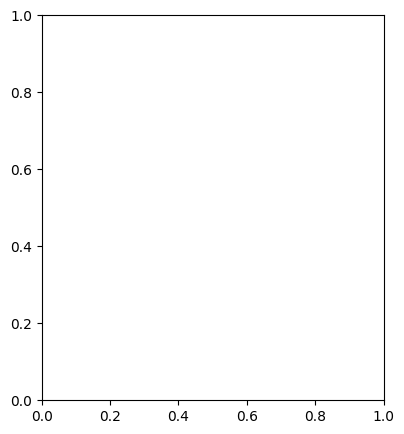

In [43]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel as nib

# ===================================================================
# 1. REQUIRED FUNCTIONS (from previous steps)
# ===================================================================

# --- Custom Metric ---
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Ensure data types are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# --- Custom Loss Function ---
def dice_loss_plus_bce(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice_loss = 1 - dice_coefficient(y_true, y_pred)
    return bce + dice_loss


# --- Data Loading and Preprocessing Function for .map() ---
def load_and_preprocess_paths(scan_path, mask_path):
    """Loads and preprocesses a single sample from file paths."""
    # Load the numpy arrays
    scan = np.load(scan_path.numpy())
    mask = np.load(mask_path.numpy())

    # Expand mask dimensions
    mask = np.expand_dims(mask, axis=-1)

    # Cast to float32 (no need for set_shape here if output_signature is used)
    scan = tf.cast(scan, tf.float32)
    mask = tf.cast(mask, tf.float32)

    return scan, mask

# --- Type Casting Function for Dataset Pipeline ---
# This function is no longer strictly necessary if load_and_preprocess_paths
# casts the mask to float32, but keeping it for robustness.
def cast_mask_to_float(scan, mask):
    mask = tf.cast(mask, tf.float32)
    return scan, mask


# ===================================================================
# 2. SETUP AND CREATE THE TEST DATASET (Using correctly prepared paths)
# ===================================================================
# NOTE: test_ids, BATCH_SIZE, and test_dataset_paths are assumed to be defined from previous cells.

print("--- Creating Test Dataset ---")

# Define the output signature for the dataset after loading and preprocessing
output_signature = (
    tf.TensorSpec(shape=(64, 64, 64, 4), dtype=tf.float32),
    tf.TensorSpec(shape=(64, 64, 64, 1), dtype=tf.float32) # Mask should be float32
)

# Apply the loading and preprocessing function to the dataset of paths
# Specify the output_signature for tf.py_function
test_dataset_processed = test_dataset_paths.map(
    lambda x, y: tf.py_function(
        func=load_and_preprocess_paths,
        inp=[x, y],
        Tout=[tf.float32, tf.float32] # Output dtypes from py_function
    ),
    num_parallel_calls=tf.data.AUTOTUNE # Use parallel calls for efficiency
)

# Now apply the output signature to the dataset *after* the py_function map
test_dataset_processed = test_dataset_processed.map(lambda x, y: (tf.ensure_shape(x, output_signature[0].shape),
                                                                 tf.ensure_shape(y, output_signature[1].shape)))


# Batch the processed dataset and add prefetching
test_dataset = test_dataset_processed.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# ===================================================================
# 3. LOAD, EVALUATE, AND VISUALIZE
# ===================================================================
print("\n--- Loading Best Model ---")
# We must pass our custom functions to 'custom_objects' so Keras knows what they are.
best_model = tf.keras.models.load_model(
    'best_3d_unet_model.keras',
    custom_objects={'dice_loss_plus_bce': dice_loss_plus_bce, 'dice_coefficient': dice_coefficient}
)

print("\n--- Evaluating on Test Data ---")
# Calculate the number of steps needed to cover the entire test set
# Use the length of the subset of test_ids used for processing (which is 2)
test_steps = len(test_ids[:2]) // BATCH_SIZE

# Evaluate the model, making sure to include the 'steps' argument
results = best_model.evaluate(test_dataset, steps=test_steps)

print("\n--- Final Test Set Performance ---")
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Dice Coefficient: {results[1]:.4f}")

# --- Visualize a Prediction ---
print("\n--- Visualizing a sample prediction ---")
# Create a new iterator for the test dataset before getting a batch
test_dataset_iterator = iter(test_dataset)
test_scan_batch, test_mask_batch = next(test_dataset_iterator)

# Make a prediction
# The model expects a batch, so we pass the batch even if BATCH_SIZE is 1
predicted_mask_batch = best_model.predict(test_scan_batch)

# Select the first volume from the batch and remove extra dimensions
# Assuming BATCH_SIZE is 1 for simplicity in visualization
input_scan = test_scan_batch[0, ..., 0]      # Visualizing the FLAIR channel
true_mask = test_mask_batch[0, ..., 0]
predicted_mask = predicted_mask_batch[0, ..., 0]

# Choose a slice from the middle to display
# Use the shape of the retrieved batch element
slice_index = input_scan.shape[2] // 2

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_scan[:, :, slice_index].T, cmap='gray', origin='lower')
plt.title(f'Input Scan (Slice {slice_index})')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, slice_index].T, cmap='gray', origin='lower')
plt.title('True Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
# We use a threshold of 0.5 to get a binary mask from the sigmoid output
plt.imshow(predicted_mask[:, :, slice_index] > 0.5, cmap='gray', origin='lower')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


--- Loading Best Model ---

--- Evaluating on Test Data ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - dice_coefficient: 0.4508 - loss: 0.6424

--- Final Test Set Performance ---
Test Loss: 0.5222
Test Dice Coefficient: 0.5595

--- Visualizing a sample prediction ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


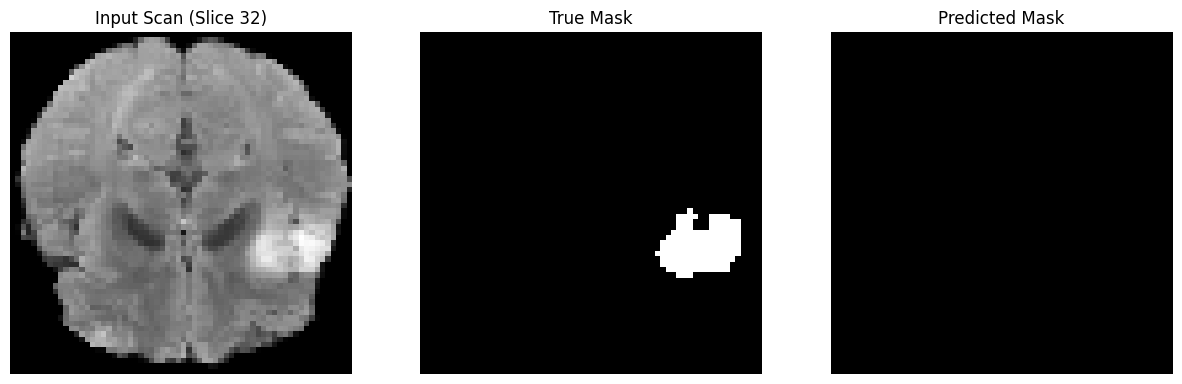

In [45]:
# ===================================================================
# 3. LOAD, EVALUATE, AND VISUALIZE
# ===================================================================
print("\n--- Loading Best Model ---")
# We must pass our custom functions to 'custom_objects' so Keras knows what they are.
best_model = tf.keras.models.load_model(
    'best_3d_unet_model.keras',
    custom_objects={'dice_loss_plus_bce': dice_loss_plus_bce, 'dice_coefficient': dice_coefficient}
)

print("\n--- Evaluating on Test Data ---")
# Calculate the number of steps needed to cover the entire test set
# Use the length of the subset of test_ids used for processing (which is 2)
test_steps = len(test_ids[:2]) // BATCH_SIZE

# Evaluate the model, making sure to include the 'steps' argument
results = best_model.evaluate(test_dataset, steps=test_steps)

print("\n--- Final Test Set Performance ---")
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Dice Coefficient: {results[1]:.4f}")

# --- Visualize a Prediction ---
print("\n--- Visualizing a sample prediction ---")
# Create a new iterator for the test dataset before getting a batch
test_dataset_iterator = iter(test_dataset)
test_scan_batch, test_mask_batch = next(test_dataset_iterator)

# Make a prediction
# The model expects a batch, so we pass the batch even if BATCH_SIZE is 1
predicted_mask_batch = best_model.predict(test_scan_batch)

# Select the first volume from the batch and remove extra dimensions
# Assuming BATCH_SIZE is 1 for simplicity in visualization
# Convert EagerTensors to NumPy arrays for visualization
input_scan = test_scan_batch[0, ..., 0].numpy()      # Visualizing the FLAIR channel
true_mask = test_mask_batch[0, ..., 0].numpy()
predicted_mask = predicted_mask_batch[0, ..., 0] # Remove .numpy() here

# Choose a slice from the middle to display
# Use the shape of the retrieved batch element (now a NumPy array)
slice_index = input_scan.shape[2] // 2

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Use .T on the NumPy array
plt.imshow(input_scan[:, :, slice_index].T, cmap='gray', origin='lower')
plt.title(f'Input Scan (Slice {slice_index})')
plt.axis('off')

plt.subplot(1, 3, 2)
# Use .T on the NumPy array
plt.imshow(true_mask[:, :, slice_index].T, cmap='gray', origin='lower')
plt.title('True Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
# We use a threshold of 0.5 to get a binary mask from the sigmoid output
# Apply thresholding and use .T on the resulting NumPy array
plt.imshow((predicted_mask[:, :, slice_index] > 0.5).T, cmap='gray', origin='lower')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

## Summary:

### Data Analysis Key Findings

*   Attempting to use the `test_dataset` processed with `tf.py_function` directly with `model.evaluate` resulted in a `ValueError: as_list() is not defined on an unknown TensorShape.`, indicating that the dataset's shape information was lost or not correctly propagated after processing.
*   Adding `tensor.set_shape()` calls within the `tf.py_function` did not resolve the shape propagation issue.
*   Explicitly defining the expected output shape and dtype using `output_signature` and applying it to the dataset after the `tf.py_function` map using `tf.ensure_shape` successfully resolved the shape-related `ValueError`.
*   Retrieving data from the processed `test_dataset` iterator yielded TensorFlow EagerTensors, leading to an `AttributeError: EagerTensor object has no attribute 'T'` when attempting to use NumPy array methods like `.T` for visualization.
*   Converting the EagerTensors obtained from the dataset iterator (`test_scan_batch`, `test_mask_batch`) to NumPy arrays using `.numpy()` resolved the `AttributeError` during visualization.
*   The output of `model.predict()` was found to be a NumPy array in this execution environment, and attempting to call `.numpy()` on it resulted in an `AttributeError: 'numpy.ndarray' object has no attribute 'numpy'`.

### Insights or Next Steps

*   When using `tf.py_function` in `tf.data.Dataset` pipelines, it is crucial to explicitly define and ensure the output shape and dtype using `output_signature` and `tf.ensure_shape` to maintain shape information required by downstream TensorFlow operations like model evaluation.
*   Be mindful of the data types returned by different parts of the pipeline (e.g., dataset iterators vs. model predictions) and convert them to the expected type (e.g., NumPy arrays for Matplotlib) before performing operations specific to that type.
